In this code we wil be using the concern of Functional API along with Data Augmentation
We wil be using the follow dataset from Kaggle which is UTKFace
Link is below :
https://www.kaggle.com/datasets/jangedoo/utkface-new

DataSet Description-

UTKFace dataset is a large-scale face dataset with long age span (range from 0 to 116 years old). The dataset consists of over 20,000 face images with annotations of age, gender, and ethnicity. The images cover large variation in pose, facial expression, illumination, occlusion, resolution, etc.

Task - TO BUILD A MODEL WITH CAN PREDICT THE AGE AND GENDER OF THE PERSON WHEN PASS THE IMAGE.

Model Description : Function API Model with Single Input and Multiple Output (2 Output) with Data Augmentation.

In [1]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [2]:
!kaggle datasets download -d jangedoo/utkface-new

 99% 329M/331M [00:01<00:00, 205MB/s]
100% 331M/331M [00:01<00:00, 187MB/s]


In [3]:
import zipfile
zip = zipfile.ZipFile('/content/utkface-new.zip')
zip.extractall('/content/')
zip.close()

In [4]:
# Importing the dependencies

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
# Storing Folder Path

folder_path = '/content/utkface_aligned_cropped/UTKFace'


In [6]:
# This code is to extract the age, gender and image path from the dataset
# As per the discription the Image name 100_0_0_20170112213500903 , consist of 3 things
# First part tells the age, 100
# Second is the gender , 0 - Male, 1 - Female
# So we will extact these both info and then create a df from it.

# We will be using following fucntion to operation the operation
# os.listdir('path') This will store the image name in the form of string
# .split('_') will convert the string into list of character split by _,
# eg "100_0_0_20170112213500903".split('_') > ['100', '0','0', '20170112213500903']
# '100' - Age , 0th index of list
# '0' - Gender , 1th index of list

age = []
gender = []
img_path =[]
for i in os.listdir(folder_path):
  age.append(int(i.split('_')[0]))  # Store the age
  gender.append(int(i.split('_')[1])) # Store the gender
  img_path.append(i) # Store the path


In [7]:
# creating a dataframe

df = pd.DataFrame({'Age':age, 'Gender':gender, 'Image_Path':img_path})
df.head()

,Age,Gender,Image_Path
0,9,0,9_0_0_20170110220058915.jpg.chip.jpg
1,52,0,52_0_0_20170117161042224.jpg.chip.jpg
2,33,0,33_0_0_20170105164910285.jpg.chip.jpg
3,16,0,16_0_0_20170110231919941.jpg.chip.jpg
4,36,1,36_1_1_20170116011443442.jpg.chip.jpg


In [8]:
# checking the shape of dataframe

df.shape

(23708, 3)

In [9]:
# Splitting the data

train = df.iloc[0:20000, :]
test = df.iloc[20000:,: ]

In [10]:
# training shape

train.shape

(20000, 3)

In [11]:
# test shape

test.shape

(3708, 3)

# Applying Data Augmentation

In [12]:
from keras.preprocessing.image import ImageDataGenerator

train_ds = ImageDataGenerator( rescale= 1/255.0,
                              rotation_range= 30,
                               width_shift_range= 0.2,
                               height_shift_range= 0.2,
                               shear_range= 0.2,
                               zoom_range=0.2,
                               horizontal_flip= True)

validation_ds = ImageDataGenerator(rescale= 1.0/255.0)

In [13]:
# Creating Generator >> we will using <ImageDataGenerator_obj>.flow_from_dataframe()

train_gen = train_ds.flow_from_dataframe(train ,
                                         directory= folder_path,
                                         x_col = 'Image_Path',
                                         y_col = ['Age', 'Gender'],
                                         target_size = (200,200),
                                         class_mode='multi_output')

test_gen = validation_ds.flow_from_dataframe(test,
                                             directory=folder_path,
                                             x_col = 'Image_Path',
                                             y_col = ['Age','Gender'],
                                             target_size = (200,200),
                                             class_mode = 'multi_output')

Found 20000 validated image filenames.
Found 3708 validated image filenames.


# Applying Transfer Learning (Feature Extraction)

In [14]:
# We wil be using VGG16() for transfer learning with Feature Extraction.


# importing the dependencies

from keras.applications.vgg16 import VGG16, preprocess_input
from keras.layers import *
from keras.models import Model

In [15]:
# declaring the pretrained model object

conv_base = VGG16(include_top=False , input_shape=(200,200,3))

# Freezing the training of conv layers

conv_base.trainable = False

58889256/58889256 [==============================] - 0s 0us/step


In [16]:
# Checking the summary

conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200, 200, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 200, 200, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 200, 200, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 100, 100, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 100, 100, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 100, 100, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 50, 50, 128)       0     

# Building the Model

In [17]:
# Defining the Layers

# Storing the output of last conv layer to perform the futher operation

output = conv_base.layers[-1].output

# Flattening
flatten = Flatten()(output)

# creating the braches

dense1 = Dense(512, activation = 'relu')(flatten) # branch 1
dense2 = Dense(512, activation = 'relu')(flatten) # branch 2

# adding layers to different branches

dense3 = Dense(512, activation = 'relu')(dense1) # branch 1 layer
dense4 = Dense(512, activation = 'relu')(dense2) # branch 2 layer

# creating the outputs

out1 = Dense(1, activation='linear', name = 'Age')(dense3)
out2 = Dense(1, activation = 'sigmoid', name = 'Gender')(dense4)

# defining the model object

model = Model(inputs= conv_base.input, outputs= [out1,out2])

# checking the summary
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 200, 200, 3)]        0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 200, 200, 64)         1792      ['input_1[0][0]']             
                                                                                                  
 block1_conv2 (Conv2D)       (None, 200, 200, 64)         36928     ['block1_conv1[0][0]']        
                                                                                                  
 block1_pool (MaxPooling2D)  (None, 100, 100, 64)         0         ['block1_conv2[0][0]']        
                                                                                              

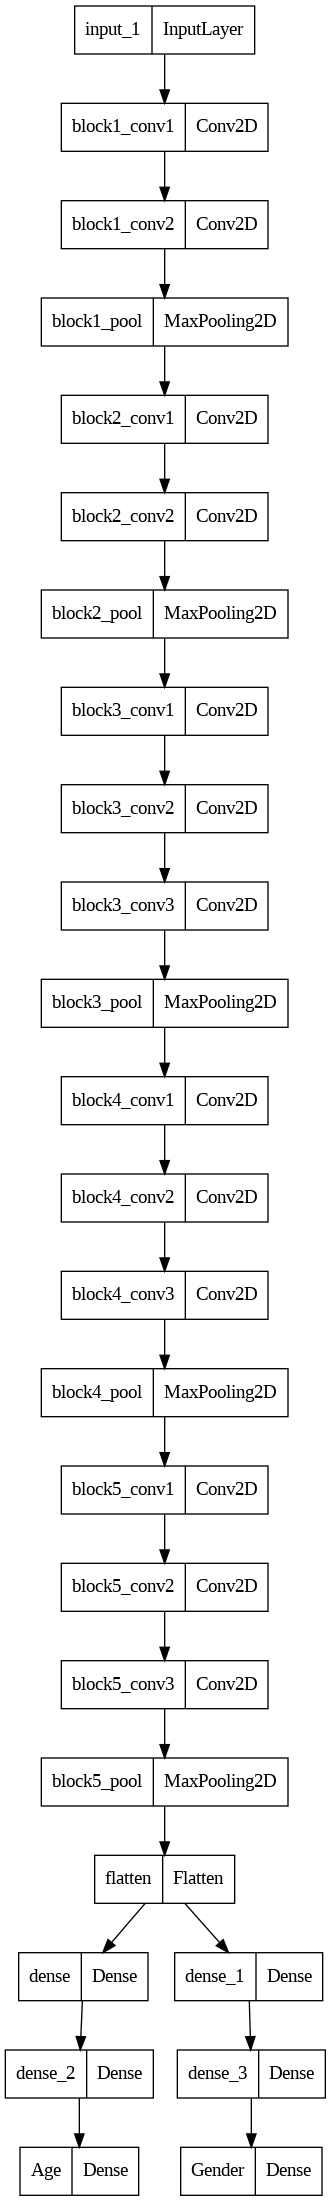

In [18]:
# Plotting the Model Architecture

from keras.src.utils import plot_model

plot_model(model)

In [19]:
# compiling the model
# Since there are 2 Output, she we will have to define 2 loss and 2 metrics,
# regression(Age) : loss = 'mse' , metrics ='mse'
# classification(Gender) : loss = 'binary_crossentropy' , metrics = 'accuracy'

model.compile(optimizer = 'adam', loss = {'Age':'mse', 'Gender':'binary_crossentropy'}, metrics ={'Age':'mse','Gender': 'accuracy'})

In [20]:
## Training the Model

history = model.fit(train_gen, batch_size = 32, epochs=10, validation_data = test_gen)

Epoch 1/10
625/625 [==============================] - 255s 383ms/step - loss: 203.3819 - Age_loss: 202.8591 - Gender_loss: 0.5227 - Age_mse: 202.8591 - Gender_accuracy: 0.7437 - val_loss: 208.6685 - val_Age_loss: 208.3149 - val_Gender_loss: 0.3537 - val_Age_mse: 208.3149 - val_Gender_accuracy: 0.8452
Epoch 2/10
625/625 [==============================] - 238s 381ms/step - loss: 164.0625 - Age_loss: 163.6280 - Gender_loss: 0.4344 - Age_mse: 163.6280 - Gender_accuracy: 0.7919 - val_loss: 131.1606 - val_Age_loss: 130.8329 - val_Gender_loss: 0.3277 - val_Age_mse: 130.8329 - val_Gender_accuracy: 0.8517
Epoch 3/10
625/625 [==============================] - 241s 385ms/step - loss: 153.8909 - Age_loss: 153.4754 - Gender_loss: 0.4155 - Age_mse: 153.4754 - Gender_accuracy: 0.8016 - val_loss: 132.0109 - val_Age_loss: 131.6935 - val_Gender_loss: 0.3175 - val_Age_mse: 131.6935 - val_Gender_accuracy: 0.8536
Epoch 4/10
625/625 [==============================] - 242s 387ms/step - loss: 149.9598 - Age_l